**Gayathree Gopi, Vannie Sung, Mason Shu, Brooks Li**

In [41]:
import numpy as np
import gurobipy as gp
import pandas as pd
import matplotlib.pyplot as plt


#### Task 1
Two csv files are included with this assignment. One of those files contains daily prices of the
index as well as the component stocks of the NASDAQ-100 in 2023. The first column is the date,
the second column is the index price (NDX), and columns 3-102 are the prices of the component
stocks. The second file is the same, except it’s 2024 prices. You’re going to use the 2023 file for
all your portfolio construction tasks and then analyze the performance on the 2024 file; that is,
how well does your portfolio, constructed with 2023 data, track the index in 2024? When we
grade your assignment, we will use different csv files with potentially a different number of days
and a different index with a different number of component stocks. You will need to calculate
the returns of the stocks in the 2023 file to calculate the correlation matrix for stock selection
and weight construction, and you will need the returns of the index for weight construction.
You will also need the daily returns in 2024 for both the index and the stocks to evaluate the
performance of your portfolio in 2024. Use the correlation matrix of returns as 𝜌.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 2024data.csv to 2024data.csv
Saving 2023data.csv to 2023data.csv


In [43]:
data_2023 = pd.read_csv('2023data.csv')
data_2024 = pd.read_csv('2024data.csv')

In [44]:
# Perform forward-fill and backward-fill to handle missing values
data_2023.ffill(inplace=True)
data_2023.bfill(inplace=True)

data_2024.ffill(inplace=True)
data_2024.bfill(inplace=True)

In [45]:
stocks = data_2023.columns[2:]

In [46]:
# Calculate daily returns for 2023 data
returns_2023 = data_2023[stocks].pct_change(fill_method=None)

In [47]:
# Step 1: Calculate the correlation matrix (similarity matrix ρ)
correlation_matrix = returns_2023.corr().values

In [48]:
# Part 1:  formulate an integer program that picks exactly m out of n stocks for our portfolio. This integer program will take as input a
# ‘similarity matrix’, which we will call 𝜌. The individual elements of this matrix, 𝜌𝑖𝑗, represent similarity between stock i and j.
"""The binary decision variables yj indicates which stocks j from the index are present in the fund (yj = 1 if j is
selected in the fund, 0 otherwise). For each stock in the index, i = 1, . . . , n, the binary decision variable xij
indicates which stock j in the index is the best representative of stock i (xij = 1 if stock j in index is the most
similar stock i, 0 otherwise).
The first constraint selects exactly m stocks to be held in the fund. The second constraint imposes that each
stock i has exactly one representative stock j in the index. The third constraint guarantees that stock i is best
represented by stock j only if j is in the fund. The objective of the model maximizes the similarity between the
n stocks and their representatives in the fund."""
# Set up parameters
n = len(stocks)  # Number of stocks
m = 5  # Number of stocks to pick for the portfolio (you can modify m as needed)

# Step 2: Set up the integer program

# Create a Gurobi model
mod = gp.Model()

# Decision variables: y_j = 1 if stock j is selected in the fund, 0 otherwise
y = mod.addVars(n, vtype='B')

# Decision variables: x_ij = 1 if stock i is represented by stock j, 0 otherwise
x = mod.addVars(n, n, vtype='B')

# Objective: Maximize the similarity (correlation) between stocks and their representatives
mod.setObjective(gp.quicksum(correlation_matrix[i][j] * x[i, j] for i in range(n) for j in range(n)), sense = gp.GRB.MAXIMIZE)

# Constraint 1: Select exactly m stocks to be in the fund
mod.addConstr(gp.quicksum(y[j] for j in range(n)) == m, "select_m_stocks")

# Constraint 2: Each stock i has exactly one representative stock j
for i in range(n):
    mod.addConstr(gp.quicksum(x[i, j] for j in range(n)) == 1, f"one_rep_{i}")

# Constraint 3: Stock i is represented by stock j only if stock j is in the fund
for i in range(n):
    for j in range(n):
        mod.addConstr(x[i, j] <= y[j], f"rep_if_in_fund_{i}_{j}")

# Solve the IP using Gurobi
mod.Params.OutputFlag = 0  # Turn off solver output for cleaner display
mod.optimize()

# Step 3: Get the results
selected_stocks = [stocks[j] for j in range(n) if y[j].x > 0.5]
print(f"Selected stocks for m={m}: {selected_stocks}")

# Step 4: Construct the portfolio weights (optional step for future implementation)
# The next step involves solving the linear program to minimize the tracking error between the portfolio and the index.

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-04
Selected stocks for m=5: ['HON', 'INTU', 'NXPI', 'PEP', 'SNPS']


In [49]:
# Note: I continued in Jupyter bc the model was too large to run on a non-academic license
# Calculate index returns
index_returns = data_2023['NDX'].pct_change(fill_method=None).iloc[1:]

# Print lengths to verify alignment
print(f"Length of index_returns: {len(index_returns)}")
print(f"Length of returns_2023: {len(returns_2023)}")

# Now we ensure that both index_returns and selected_stock_returns have compatible lengths
# Find the intersection of valid indices from both datasets
valid_indices = returns_2023.index.intersection(index_returns.index)

# Align both datasets by their valid indices
selected_stock_returns = returns_2023.loc[valid_indices, selected_stocks].values
index_returns = index_returns.loc[valid_indices].values

# Now index_returns and selected_stock_returns should have the same number of rows
T = len(index_returns)  # Number of time periods
m = len(selected_stocks)  # Number of selected stocks

# Create a Gurobi model for portfolio weight calculation
mod_weights = gp.Model()

# Decision variables: weights of the selected stocks
weights = mod_weights.addVars(m, lb=0, name="weights")  # Weights should be non-negative

# Auxiliary variables for the absolute deviation between portfolio returns and index returns
deviation = mod_weights.addVars(T, lb=0, name="deviation")

# Objective: Minimize the sum of absolute deviations (minimize tracking error)
mod_weights.setObjective(gp.quicksum(deviation[t] for t in range(T)), sense=gp.GRB.MINIMIZE)

# Constraint 1: The sum of weights must equal 1 (portfolio fully invested)
mod_weights.addConstr(gp.quicksum(weights[j] for j in range(m)) == 1, "weights_sum")

# Constraint 2: Absolute deviation between portfolio return and index return
for t in range(T):
    # Calculate the portfolio return at time t using the selected stock returns
    portfolio_return_t = gp.quicksum(weights[j] * selected_stock_returns[t, j] for j in range(m))

    # Constraints to minimize absolute deviation
    mod_weights.addConstr(deviation[t] >= portfolio_return_t - index_returns[t], f"dev_pos_{t}")
    mod_weights.addConstr(deviation[t] >= index_returns[t] - portfolio_return_t, f"dev_neg_{t}")

# Solve the LP using Gurobi
mod_weights.Params.OutputFlag = 0
mod_weights.optimize()

# Step 6: Get the portfolio weights
optimal_weights = [weights[j].X for j in range(m)]
print(f"Optimal weights for selected stocks: {optimal_weights}")

# Combine the selected stocks with their weights
portfolio = pd.DataFrame({
    'Stock': selected_stocks,
    'Weight': optimal_weights
})

print("Portfolio with selected stocks and their weights:")
print(portfolio)

Length of index_returns: 249
Length of returns_2023: 250
Optimal weights for selected stocks: [0.16201314266179717, 0.22008574613522103, 0.17479043860424387, 0.1985933357717476, 0.24451733682699034]
Portfolio with selected stocks and their weights:
  Stock    Weight
0   HON  0.162013
1  INTU  0.220086
2  NXPI  0.174790
3   PEP  0.198593
4  SNPS  0.244517


In [50]:
# Calculate the returns for the selected stocks in 2024
returns_2024 = data_2024[selected_stocks].pct_change(fill_method=None).iloc[1:]

# Extract index returns for 2024 (assuming 'NDX' is the index column)
index_returns_2024 = data_2024['NDX'].pct_change(fill_method=None)

# Align both datasets by their common indices
common_indices = returns_2024.index.intersection(index_returns_2024.index)

# Trim both datasets to the common indices
selected_stock_returns_2024 = returns_2024.loc[common_indices].values
index_returns_2024 = index_returns_2024.loc[common_indices].values

# Now ensure that both datasets are properly aligned
T_2024 = len(index_returns_2024)
assert selected_stock_returns_2024.shape[0] == T_2024, f"Mismatch: selected_stock_returns_2024 has {selected_stock_returns_2024.shape[0]} rows, but index_returns_2024 has {T_2024} rows."

# Use the weights from 2023
optimal_weights_2023 = [0.16201314266179717, 0.22008574613522103, 0.17479043860424387, 0.1985933357717476, 0.24451733682699034]

# Calculate the absolute difference between the portfolio return and the index return for 2024
tracking_error_2024 = 0

for t in range(T_2024):
    # Calculate the portfolio return at time t in 2024 using the 2023 weights
    portfolio_return_t = sum(optimal_weights_2023[j] * selected_stock_returns_2024[t, j] for j in range(5))

    # Calculate the absolute difference between portfolio return and index return
    tracking_error_2024 += abs(index_returns_2024[t] - portfolio_return_t)

# Output the tracking error
tracking_error_2024

1.147253740764911

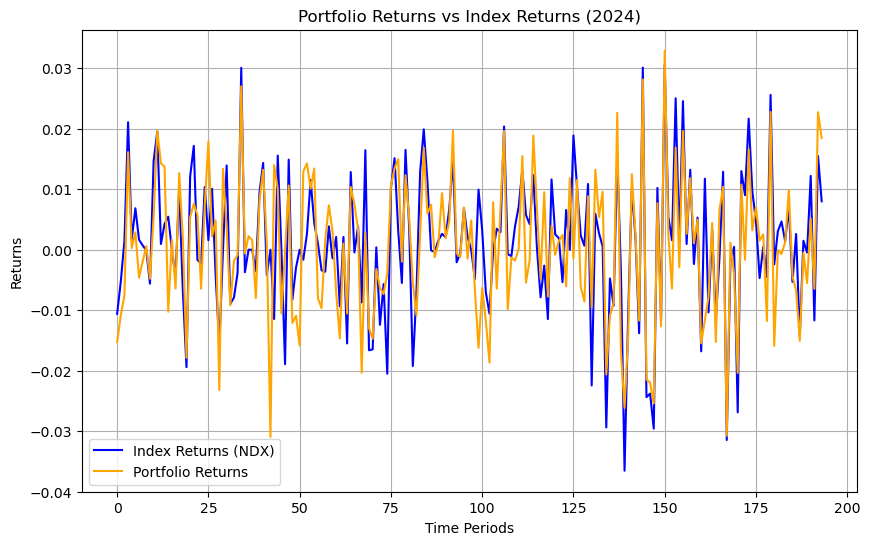

In [51]:
# Visualizing the tracking error for m = 5
# Re-load the 2024 data to ensure alignment

# Ensure the 2024 selected stock returns match the index returns
assert selected_stock_returns_2024.shape[0] == T_2024, f"Mismatch: selected_stock_returns_2024 has {selected_stock_returns_2024.shape[0]} rows, but index_returns_2024 has {T_2024} rows."

# Calculate portfolio returns over time using the optimal weights from 2023 for 2024 data
portfolio_returns_2024 = np.sum(optimal_weights_2023 * selected_stock_returns_2024, axis=1)

time_periods = np.arange(T_2024)

# Plot the portfolio returns vs index returns over time
plt.figure(figsize=(10, 6))

# Plot index returns
plt.plot(time_periods, index_returns_2024, label='Index Returns (NDX)', color='blue')

# Plot portfolio returns
plt.plot(time_periods, portfolio_returns_2024, label='Portfolio Returns', color='orange')

# Add title and labels
plt.title('Portfolio Returns vs Index Returns (2024)')
plt.xlabel('Time Periods')
plt.ylabel('Returns')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

#### Task 3

In [75]:
# Load the 2023 and 2024 data
data_2023 = pd.read_csv('2023data.csv')
data_2024 = pd.read_csv('2024data.csv')

# Perform forward-fill and backward-fill to handle missing values
data_2023.ffill(inplace=True)
data_2023.bfill(inplace=True)
data_2024.ffill(inplace=True)
data_2024.bfill(inplace=True)

# Ensure all columns are numeric (except 'Date')
data_2023 = data_2023.drop(columns='Date').apply(pd.to_numeric, errors='coerce')
data_2024 = data_2024.drop(columns='Date').apply(pd.to_numeric, errors='coerce')

# Calculate percentage changes (returns) for 2023 and 2024
returns_2023 = data_2023.pct_change(fill_method=None).iloc[1:]
returns_2024 = data_2024.pct_change(fill_method=None).iloc[1:]

# Extract index returns (assuming 'NDX' is the index column)
index_returns_2023 = returns_2023['NDX'].values
index_returns_2024 = returns_2024['NDX'].values

# Number of total stocks in the data
total_stocks = len(returns_2023.columns) - 1  # Subtract 1 for 'NDX' column
stock_names = returns_2023.columns[1:]  # Assuming first column is 'NDX', rest are stocks

# Initialize lists to store tracking errors
tracking_errors_2023 = []
tracking_errors_2024 = []

# Iterate over m values (10, 20, ..., 100, or total available stocks)
for m in range(10, min(total_stocks, 100) + 1, 10):
    # Part 1 Optimization to select the best m stocks
    mod_selection = gp.Model()
    
    # Decision variables for stock selection
    y = mod_selection.addVars(total_stocks, vtype=gp.GRB.BINARY, name="y")  # Binary variables for stock selection
    x = mod_selection.addVars(total_stocks, total_stocks, vtype=gp.GRB.BINARY, name="x")  # Binary variables for representation

    # Define the objective to maximize correlation similarity (similarity matrix `rho`)
    rho = returns_2023[stock_names].corr().values  # Correlation matrix as similarity matrix
    mod_selection.setObjective(gp.quicksum(x[i, j] * rho[i, j] for i in range(total_stocks) for j in range(total_stocks)), gp.GRB.MAXIMIZE)

    # Constraints to select exactly m stocks
    mod_selection.addConstr(gp.quicksum(y[j] for j in range(total_stocks)) == m)

    # Each stock i must have one representative
    mod_selection.addConstrs((gp.quicksum(x[i, j] for j in range(total_stocks)) == 1 for i in range(total_stocks)))

    # A stock i is represented by stock j only if stock j is selected
    mod_selection.addConstrs((x[i, j] <= y[j] for i in range(total_stocks) for j in range(total_stocks)))

    # Solve the model for stock selection
    mod_selection.Params.OutputFlag = 0
    mod_selection.optimize()

    # Extract selected stocks based on optimization results
    selected_stocks = [stock_names[j] for j in range(total_stocks) if y[j].X > 0.5]

    # Align both datasets by their valid indices
    valid_indices = returns_2023.index.intersection(returns_2023.index)
    selected_stock_returns = returns_2023.loc[valid_indices, selected_stocks].values
    index_returns = index_returns_2023

    T = len(index_returns)  # Number of time periods for 2023

    # Create a Gurobi model for portfolio weight calculation
    mod_weights = gp.Model()
    weights = mod_weights.addVars(m, lb=0, name="weights")  # Weights should be non-negative
    deviation = mod_weights.addVars(T, lb=0, name="deviation")  # Auxiliary variables for deviation

    # Objective: Minimize the sum of absolute deviations (tracking error)
    mod_weights.setObjective(gp.quicksum(deviation[t] for t in range(T)), sense=gp.GRB.MINIMIZE)

    # Constraint 1: The sum of weights must equal 1
    mod_weights.addConstr(gp.quicksum(weights[j] for j in range(m)) == 1, "weights_sum")

    # Constraint 2: Absolute deviation between portfolio return and index return
    for t in range(T):
        portfolio_return_t = gp.quicksum(weights[j] * selected_stock_returns[t, j] for j in range(m))
        mod_weights.addConstr(deviation[t] >= portfolio_return_t - index_returns[t])
        mod_weights.addConstr(deviation[t] >= index_returns[t] - portfolio_return_t)

    # Solve the model
    mod_weights.Params.OutputFlag = 0  # Suppress output
    mod_weights.optimize()

    # Get the optimal weights
    optimal_weights = [weights[j].X for j in range(m)]

    # Evaluate performance in 2023 (in-sample tracking error)
    tracking_error_2023 = 0
    for t in range(T):
        portfolio_return_t = sum(optimal_weights[j] * selected_stock_returns[t, j] for j in range(m))
        tracking_error_2023 += abs(index_returns[t] - portfolio_return_t)
    tracking_errors_2023.append(tracking_error_2023)

    # Now evaluate the performance on the 2024 data
    returns_2024_selected = returns_2024[selected_stocks]
    selected_stock_returns_2024 = returns_2024_selected.values

    T_2024 = len(index_returns_2024)

    # Evaluate performance in 2024 (out-of-sample tracking error)
    tracking_error_2024 = 0
    for t in range(T_2024):
        portfolio_return_t_2024 = sum(optimal_weights[j] * selected_stock_returns_2024[t, j] for j in range(m))
        tracking_error_2024 += abs(index_returns_2024[t] - portfolio_return_t_2024)
    tracking_errors_2024.append(tracking_error_2024)

# Output tracking errors for 2023 and 2024
print("Tracking Errors in 2023 (in-sample):", tracking_errors_2023)
print("Tracking Errors in 2024 (out-of-sample):", tracking_errors_2024)


Tracking Errors in 2023 (in-sample): [0.9685635855478847, 0.8899410213523036, 0.7880728266329018, 0.6744653887656368, 0.5754432211230489, 0.5461315740380612, 0.39247487745119025, 0.26706876018661385, 0.21662771152644694, 0.20585505263176293]
Tracking Errors in 2024 (out-of-sample): [0.8780345557932459, 0.7866258111331785, 0.7189073122894641, 0.7287099220832528, 0.6872240984089951, 0.6691561394215185, 0.6034054593593162, 0.5070414482038076, 0.4336451263231583, 0.40992661642343226]


In [77]:
# Define the updated tracking errors for 2023 and 2024
tracking_errors_2023 = [0.9685635855478847, 0.8899410213523036, 0.7880728266329018, 0.6744653887656368,
                        0.5754432211230489, 0.5461315740380612, 0.39247487745119025, 0.26706876018661385,
                        0.21662771152644694, 0.20585505263176293]
tracking_errors_2024 = [0.8780345557932459, 0.7866258111331785, 0.7189073122894641, 0.7287099220832528,
                        0.6872240984089951, 0.6691561394215185, 0.6034054593593162, 0.5070414482038076,
                        0.4336451263231583, 0.40992661642343226]

# Define m_values based on the tracking errors for 2023 and 2024
m_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Create the dataframe
tracking_error_df = pd.DataFrame({
    'm': m_values,
    'Tracking Error 2023 (in-sample)': tracking_errors_2023,
    'Tracking Error 2024 (out-of-sample)': tracking_errors_2024
})

# Display the dataframe
tracking_error_df


,m,Tracking Error 2023 (in-sample),Tracking Error 2024 (out-of-sample)
0,10,0.968564,0.878035
1,20,0.889941,0.786626
2,30,0.788073,0.718907
3,40,0.674465,0.728710
4,50,0.575443,0.687224
5,60,0.546132,0.669156
6,70,0.392475,0.603405
7,80,0.267069,0.507041
8,90,0.216628,0.433645
9,100,0.205855,0.409927


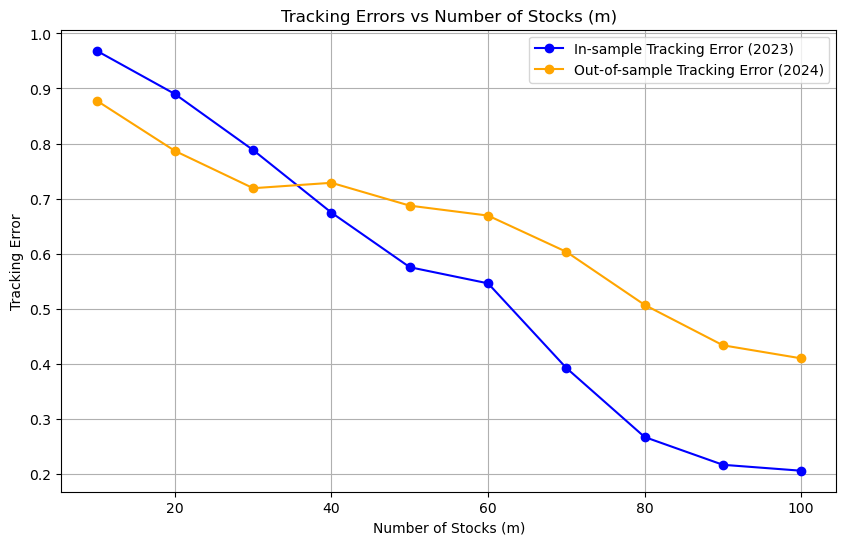

In [79]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot in-sample (2023) tracking errors
plt.plot(m_values, tracking_errors_2023, label='In-sample Tracking Error (2023)', marker='o', color='blue')

# Plot out-of-sample (2024) tracking errors
plt.plot(m_values, tracking_errors_2024, label='Out-of-sample Tracking Error (2024)', marker='o', color='orange')

# Add title and labels
plt.title('Tracking Errors vs Number of Stocks (m)')
plt.xlabel('Number of Stocks (m)')
plt.ylabel('Tracking Error')
plt.legend()

# Add a grid for better visualization
plt.grid(True)

# Display the plot
plt.show()

#### Task 4

In [57]:
# A safer version of what I ran that won't start over if you accidentally shut down your laptop
import pandas as pd
import gurobipy as gp
import numpy as np
import os

# Define time limit in seconds (3600 seconds = 1 hour)
time_limit = 3600

# Load 2023 and 2024 data
data_2023 = pd.read_csv('2023data.csv')
data_2024 = pd.read_csv('2024data.csv')

# Perform forward-fill and backward-fill to handle missing values
data_2023.ffill(inplace=True)
data_2023.bfill(inplace=True)

data_2024.ffill(inplace=True)
data_2024.bfill(inplace=True)

# Ensure all columns are numeric (except 'Date')
data_2023 = data_2023.drop(columns='Date').apply(pd.to_numeric, errors='coerce')
data_2024 = data_2024.drop(columns='Date').apply(pd.to_numeric, errors='coerce')

# Calculate percentage changes (returns) for 2023 and 2024
returns_2023 = data_2023.pct_change(fill_method=None).iloc[1:]
returns_2024 = data_2024.pct_change(fill_method=None).iloc[1:]

# Extract index returns (assuming 'NDX' is the index column)
index_returns_2023 = returns_2023['NDX'].values
index_returns_2024 = returns_2024['NDX'].values

# Define the number of stocks and stock names
n = len(returns_2023.columns) - 1  # Subtract 1 for the 'NDX' column
stock_names = returns_2023.columns[1:]  # Assuming first column is 'NDX', rest are stocks

# Define Big M as 1 (maximum possible weight)
M = 1

# Check if the CSV file with saved results exists
csv_file = 'tracking_error_results.csv'
if os.path.exists(csv_file):
    saved_results = pd.read_csv(csv_file)
    already_computed_m = saved_results['m'].tolist()
else:
    saved_results = pd.DataFrame(columns=['m', 'Tracking Error 2023 (in-sample)', 'Tracking Error 2024 (out-of-sample)'])
    already_computed_m = []

# Iterate over m values (10, 20, ..., 100)
for m in range(10, min(n, 100) + 1, 10):
    if m in already_computed_m:
        print(f"Skipping m={m} as it's already computed.")
        continue  # Skip already computed values

    # Create a Gurobi model
    mod = gp.Model()

    # Decision variables: weights and binary variables
    w = mod.addVars(n, lb=0, ub=1, name="weights")  # Weights should be between 0 and 1
    y = mod.addVars(n, vtype=gp.GRB.BINARY, name="y")  # Binary variables for stock inclusion

    # Objective: Minimize tracking error
    T = len(index_returns_2023)  # Number of time periods in 2023
    deviation = mod.addVars(T, lb=0, name="deviation")  # Absolute deviation variables

    # Set the objective to minimize tracking error
    mod.setObjective(gp.quicksum(deviation[t] for t in range(T)), sense=gp.GRB.MINIMIZE)

    # Constraint 1: The sum of weights must equal 1 (fully invested portfolio)
    mod.addConstr(gp.quicksum(w[i] for i in range(n)) == 1, "weights_sum")

    # Constraint 2: Ensure w[i] = 0 if y[i] = 0 using the Big M technique
    for i in range(n):
        mod.addConstr(w[i] <= M * y[i], f"bigM_constraint_{i}")

    # Constraint 3: The sum of binary variables y[i] must equal m (exactly m stocks in the portfolio)
    mod.addConstr(gp.quicksum(y[i] for i in range(n)) == m, "select_m_stocks")

    # Constraint 4: Minimize absolute deviation between portfolio return and index return
    stock_returns_2023 = returns_2023[stock_names].values
    for t in range(T):
        portfolio_return_t = gp.quicksum(w[i] * stock_returns_2023[t, i] for i in range(n))
        mod.addConstr(deviation[t] >= portfolio_return_t - index_returns_2023[t])
        mod.addConstr(deviation[t] >= index_returns_2023[t] - portfolio_return_t)

    # Set Gurobi parameters (including the time limit)
    mod.Params.OutputFlag = 0  # Suppress Gurobi output
    mod.Params.TimeLimit = time_limit  # Set time limit to 1 hour (3600 seconds)

    # Solve the model
    mod.optimize()

    # Get the optimal weights (if a solution is found within the time limit)
    optimal_weights = [w[i].X if w[i].X > 0 else 0 for i in range(n)]

    # Evaluate the tracking error for 2023 (in-sample)
    tracking_error_2023 = 0
    for t in range(T):
        portfolio_return_t = sum(optimal_weights[i] * stock_returns_2023[t, i] for i in range(n))
        tracking_error_2023 += abs(index_returns_2023[t] - portfolio_return_t)

    # Now evaluate the performance on the 2024 data (out-of-sample)
    stock_returns_2024 = returns_2024[stock_names].values
    T_2024 = len(index_returns_2024)

    tracking_error_2024 = 0
    for t in range(T_2024):
        portfolio_return_t_2024 = sum(optimal_weights[i] * stock_returns_2024[t, i] for i in range(n))
        tracking_error_2024 += abs(index_returns_2024[t] - portfolio_return_t_2024)

    # Save results to DataFrame
    result = pd.DataFrame({
        'm': [m],
        'Tracking Error 2023 (in-sample)': [tracking_error_2023],
        'Tracking Error 2024 (out-of-sample)': [tracking_error_2024]
    })

    # Append the result to the existing CSV file
    result.to_csv(csv_file, mode='a', header=not os.path.exists(csv_file), index=False)

    print(f"Completed m={m} and saved results.")

Completed m=10 and saved results.
Completed m=20 and saved results.
Completed m=30 and saved results.
Completed m=40 and saved results.
Completed m=50 and saved results.
Completed m=60 and saved results.
Completed m=70 and saved results.
Completed m=80 and saved results.
Completed m=90 and saved results.
Completed m=100 and saved results.


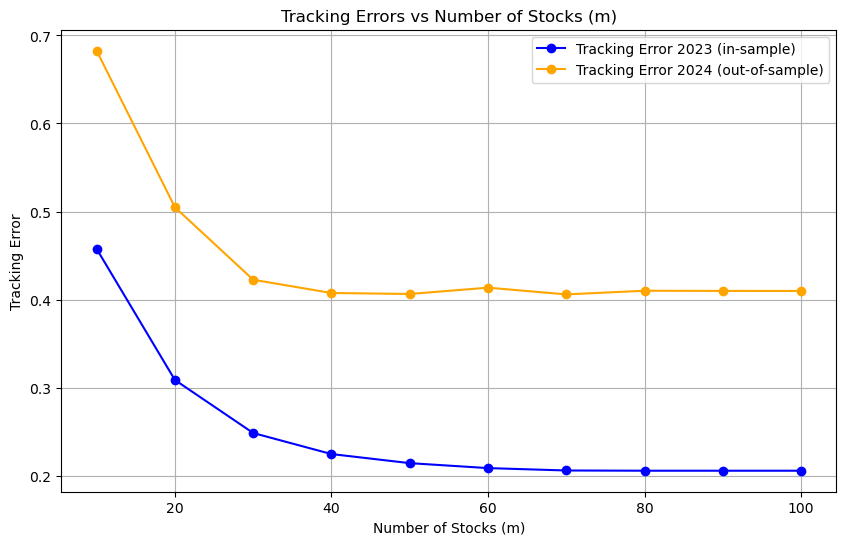

In [81]:
# Plotting the results once they finally come out
# Load your CSV file (adjust the file path as needed)
tracking_error_df = pd.read_csv('tracking_error_results.csv')

# Plot the data
plt.figure(figsize=(10, 6))

# Plot in-sample (2023) tracking errors
plt.plot(tracking_error_df['m'], tracking_error_df['Tracking Error 2023 (in-sample)'], label='Tracking Error 2023 (in-sample)', marker='o', color='blue')

# Plot out-of-sample (2024) tracking errors
plt.plot(tracking_error_df['m'], tracking_error_df['Tracking Error 2024 (out-of-sample)'], label='Tracking Error 2024 (out-of-sample)', marker='o', color='orange')

# Add title and labels
plt.title('Tracking Errors vs Number of Stocks (m)')
plt.xlabel('Number of Stocks (m)')
plt.ylabel('Tracking Error')
plt.legend()

# Add a grid for better visualization
plt.grid(True)

# Display the plot
plt.show()